In [1]:
import io
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium import plugins as foliumPlugins

In [2]:
sns.set()

In [3]:
# Request zip on AWS
print('load data from AWS')
file_url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+2+Participez+%C3%A0+un+concours+sur+la+Smart+City/p2-arbres-fr.csv'
response = requests.get(file_url)

# Read it in pandas
print('Read csv by pandas')
df = pd.read_csv(io.BytesIO(response.content), sep=';')
df_save = df.copy()

load data from AWS
Read csv by pandas


# 1. Présentation générale du jeu de données

## 1.1. Apperçu des données

In [4]:
df.head()

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
4,99878,Arbre,Jardin,PARIS 17E ARRDT,NaN,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38,0,NaN,NaN,48.890435,2.315289


## 1.2. Caractéristiques des données

### 1.2.1. Lignes (individus) / Colonnes (variables)

In [5]:
individus = df.shape[0]
variables = df.shape[1]
print(f'Les données contiennent {individus} lignes et {variables} colonnes')

Les données contiennent 200137 lignes et 18 colonnes


In [6]:
columns = df.columns
columns
print('Liste des colonnes: ')
print('- ', end='')
print(*columns, sep = '\n- ')

Liste des colonnes: 
- id
- type_emplacement
- domanialite
- arrondissement
- complement_addresse
- numero
- lieu
- id_emplacement
- libelle_francais
- genre
- espece
- variete
- circonference_cm
- hauteur_m
- stade_developpement
- remarquable
- geo_point_2d_a
- geo_point_2d_b


### 1.2.2. Type des données

In [7]:
df.dtypes

id                       int64
type_emplacement        object
domanialite             object
arrondissement          object
complement_addresse     object
numero                 float64
lieu                    object
id_emplacement          object
libelle_francais        object
genre                   object
espece                  object
variete                 object
circonference_cm         int64
hauteur_m                int64
stade_developpement     object
remarquable            float64
geo_point_2d_a         float64
geo_point_2d_b         float64
dtype: object

Pas de problème dans les types de données. Les variables quantitatives sont bien reconnues en tant que valeurs numériques

### 1.2.3. Données dupliquées

In [8]:
df.loc[df.duplicated(keep=False, subset=['id_emplacement','geo_point_2d_a', 'geo_point_2d_b']),:]

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
189133,2011522,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,190042,Peuplier,Populus,nigra,NaN,0,0,NaN,0.0,48.836416,2.446277
189134,2011523,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,190042,Peuplier,Populus,nigra,Italica',100,22,A,0.0,48.836416,2.446277


Un arbre est dupliqué (même id emplacement, même geo point). Le premier contenant moins d'informations est supprimé.

In [9]:
df = df[df.index != 189133]

### 1.2.4. Données manquantes

In [10]:
df.isna().mean().sort_values(ascending=False)

numero                 1.000000
complement_addresse    0.845595
variete                0.816240
stade_developpement    0.335792
remarquable            0.315276
espece                 0.008754
libelle_francais       0.007480
genre                  0.000080
domanialite            0.000005
circonference_cm       0.000000
geo_point_2d_a         0.000000
hauteur_m              0.000000
id                     0.000000
type_emplacement       0.000000
id_emplacement         0.000000
lieu                   0.000000
arrondissement         0.000000
geo_point_2d_b         0.000000
dtype: float64

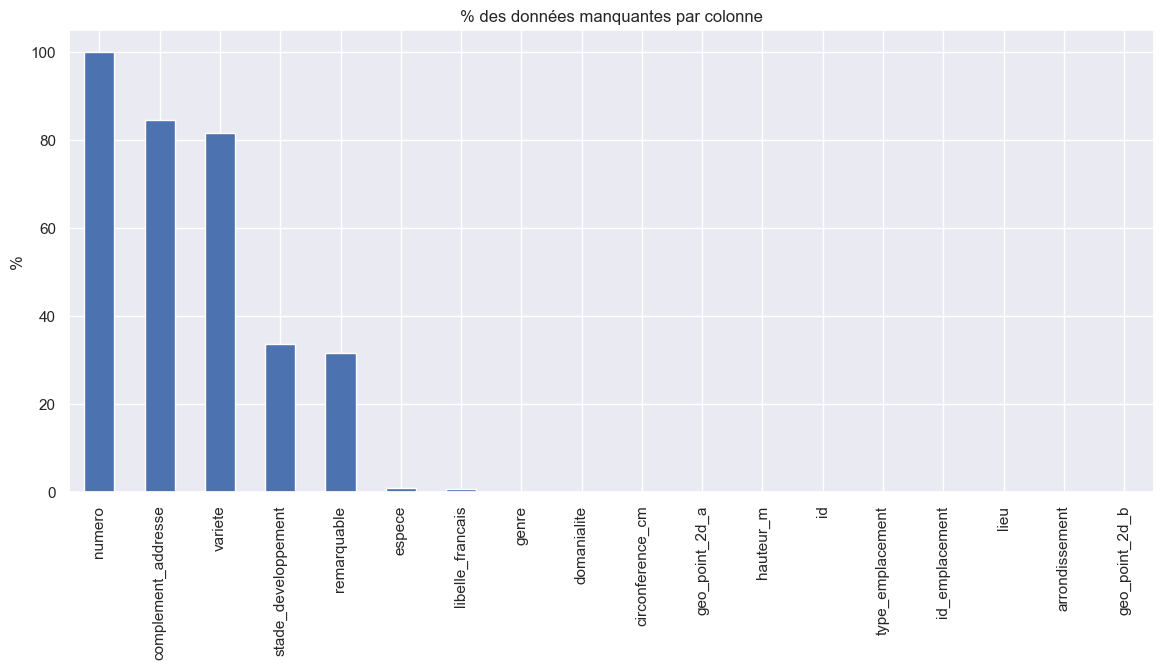

In [11]:
plt.figure(figsize=(14,6))
(df.isna().mean().sort_values(ascending=False)*100).plot.bar()
plt.title('% des données manquantes par colonne')
plt.ylabel('%')
plt.show()

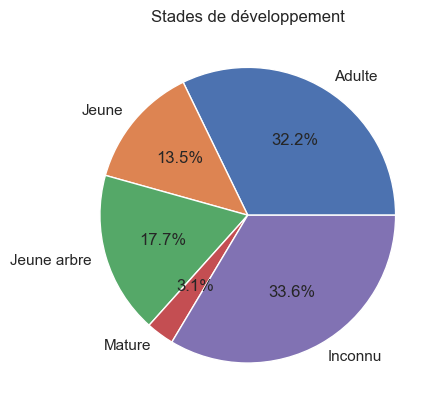

In [12]:
plt.figure()
df_stade_developpement = df.groupby(['stade_developpement'], dropna=False).size()
df_stade_developpement = df_stade_developpement.reset_index()
df_stade_developpement.loc[df_stade_developpement['stade_developpement'] == 'A', 'stade_developpement'] = 'Adulte'
df_stade_developpement.loc[df_stade_developpement['stade_developpement'] == 'J', 'stade_developpement'] = 'Jeune'
df_stade_developpement.loc[df_stade_developpement['stade_developpement'] == 'JA', 'stade_developpement'] = 'Jeune arbre'
df_stade_developpement.loc[df_stade_developpement['stade_developpement'] == 'M', 'stade_developpement'] = 'Mature'
df_stade_developpement.loc[df_stade_developpement['stade_developpement'].isna(), 'stade_developpement'] = 'Inconnu'
df_stade_developpement.set_index('stade_developpement', inplace=True)
df_stade_developpement.squeeze().plot.pie(label='', autopct='%1.1f%%')
plt.title('Stades de développement')
plt.show()

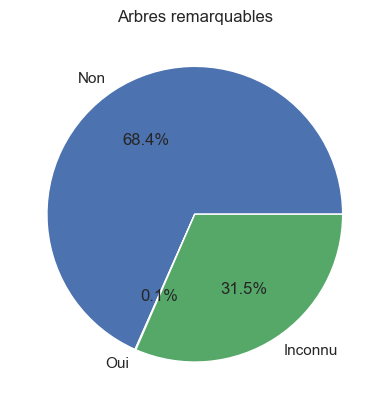

In [13]:
plt.figure()
df_remarquable = df.groupby(['remarquable'], dropna=False).size()
df_remarquable = df_remarquable.reset_index()
df_remarquable.loc[df_remarquable['remarquable'] == 0, 'remarquable'] = 'Non'
df_remarquable.loc[df_remarquable['remarquable'] == 1, 'remarquable'] = 'Oui'
df_remarquable.loc[df_remarquable['remarquable'].isna(), 'remarquable'] = 'Inconnu'
df_remarquable.set_index('remarquable', inplace=True)
df_remarquable.squeeze().plot.pie(label='', autopct='%1.1f%%')
plt.title('Arbres remarquables')
plt.show()

In [14]:
df['type_emplacement'].unique()

array(['Arbre'], dtype=object)

# 2. Démarche méthodologique d’analyse de données

1. <ins>Néttoyage du jeu de données</ins>
    - Colonnes vides / inutiles / hors sujet / hors compétence
    - Valeurs abérantes
2. <ins>Analyse univariée des colonnes circonference et hauteur</ins>
    - Description, min, max, ecart type, quartiles
    - Histogramme distributions / concentrations
    - Boite à moustache des dispersions

## 2.1. Néttoyage du jeu de données
- La colonne id est inutile pour l'analyse et sera supprimée
- La colonne "numero" est vide elle sera exclue
- La colonne "type_emplacement" ne possède qu'une même valeur unique pour tous les individus: "Arbre". Elle n'a aucune utilité et sera supprimée
- Les colonnes "geo_point_2d_" seront exclues du jeu de données car je n'ai pas de connaissance dans ce domaine
- Les colonnes "complement_adresse" et "variete" sont très vides avec un taux respectif de seulement 15%, 19% de données remplies. Elles seront supprimées
- La colonne "remarquable" n'est remplie qu'à 69% et cette donnée binaire n'est pas imputable, elles sera supprimée.
- La colonne "stade_developpement" est aussi assez vide avec un taux respectif de 67% de données remplies. Cette donnée catégorielle est peut-être imputable en cherchant par apprentissage (kmeans) avec les variables diametre/espece (hors sujet de cette etude). Cette colonne sera supprimée
- Les colonnes "domanialite", "libelle_francais", "genre" et "espece" contiennent quelques valeurs vides (< 0.8%), non imputables, les lignes seront supprimées en fonction de l'analyse faite.<br> Exemple: si l'analyse est bivariée et concerne le diamètre par domanialité, alors les lignes dont la domanialité n'est pas connues seront supprimées)

In [15]:
df.drop(['id', 'numero', 'type_emplacement', 'geo_point_2d_a', 'geo_point_2d_b', 'complement_addresse', 'variete', 'remarquable', 'stade_developpement'], axis=1, inplace=True)

In [16]:
df.describe()

,circonference_cm,hauteur_m
count,200136.000000,200136.000000
mean,83.380896,13.110575
std,673.191869,1971.222311
min,0.000000,0.000000
25%,30.000000,5.000000
50%,70.000000,8.000000
75%,115.000000,12.000000
max,250255.000000,881818.000000


Pour les 2 colonnes les valeurs min et max sont aberrantes (circonference et hauteur nulle, circonference de 250m et hauteur de 881km)
Avec un peu de recherche (https://www.unjourdeplusaparis.com/paris-vert/arbres-remarquables-paris) on apprend que pour Paris

- La circonférence du plus gros arbre est de 7m
- La hauteur du plus grand arbre est 35m

On pourrait utiliser ces valeurs, mais je vais filtrer mon jeu de données en utilisant les quartiles

In [17]:
circonference_min = df['circonference_cm'].quantile(0.25)  - 1.5 * (df['circonference_cm'].quantile(0.75) - df['circonference_cm'].quantile(0.25))
circonference_max = df['circonference_cm'].quantile(0.75)  + 1.5 * (df['circonference_cm'].quantile(0.75) - df['circonference_cm'].quantile(0.25))

hauteur_min = df['hauteur_m'].quantile(0.25)  - 1.5 * (df['hauteur_m'].quantile(0.75) - df['hauteur_m'].quantile(0.25))
hauteur_max = df['hauteur_m'].quantile(0.75)  + 1.5 * (df['hauteur_m'].quantile(0.75) - df['hauteur_m'].quantile(0.25))

filtre_circonference = (df['circonference_cm'] > 0) & (df['circonference_cm'] > circonference_min) & (df['circonference_cm'] < circonference_max)
filtre_hauteur = (df['hauteur_m'] > 0) & (df['hauteur_m'] > hauteur_min) & (df['hauteur_m'] < hauteur_max)

Liste de arbres dont la circonférence est considérée abérantes (=0 ou au-dessous de  Q1−1.5IQ ou au-dessus de Q3+1.5IQ)

In [18]:
df.loc[~filtre_circonference, :].sort_values('circonference_cm', ascending=False)

,domanialite,arrondissement,lieu,id_emplacement,libelle_francais,genre,espece,circonference_cm,hauteur_m
149056,Alignement,PARIS 18E ARRDT,PLACE DE LA CHAPELLE,101026,Platane,Platanus,x hispanica,250255,22
160432,Alignement,PARIS 18E ARRDT,AVENUE DE LA PORTE DE CLIGNANCOURT,202005,Platane,Platanus,orientalis,120170,20
173343,Alignement,PARIS 5E ARRDT,BOULEVARD DE PORT ROYAL,402001,Marronnier,Aesculus,x carnea,79120,10
147634,Alignement,PARIS 7E ARRDT,AVENUE BOSQUET,1202016,Platane,Platanus,occidentalis,65110,16
91256,Alignement,PARIS 12E ARRDT,RUE DE CHALON,202005,Micocoulier,Celtis,australis,30140,10
...,...,...,...,...,...,...,...,...,...
46384,CIMETIERE,SEINE-SAINT-DENIS,CIMETIERE DE PANTIN / AVENUE DE L'AQUEDUC / DI...,A03100F24031,Charme,Carpinus,betulus,0,0
46383,CIMETIERE,SEINE-SAINT-DENIS,CIMETIERE DE PANTIN / AVENUE DE L'AQUEDUC / DI...,A03100F24030,Charme,Carpinus,betulus,0,0
46382,CIMETIERE,SEINE-SAINT-DENIS,CIMETIERE DE PANTIN / AVENUE DE L'AQUEDUC / DI...,A03100F24029,Charme,Carpinus,betulus,0,0
46381,CIMETIERE,SEINE-SAINT-DENIS,CIMETIERE DE PANTIN / AVENUE DE L'AQUEDUC / DI...,A03100F24028,Charme,Carpinus,betulus,0,0


Liste des arbres dont la hauteur est considérée comme abérante (=0 ou au-dessous de  Q1−1.5IQ ou au-dessus de Q3+1.5IQ)

In [19]:
df.loc[~filtre_hauteur, :].sort_values('hauteur_m', ascending=False)

,domanialite,arrondissement,lieu,id_emplacement,libelle_francais,genre,espece,circonference_cm,hauteur_m
182852,Alignement,BOIS DE VINCENNES,ROUTE DE LA PYRAMIDE,301046,Tilleul,Tilia,tomentosa,125,881818
150101,Alignement,PARIS 11E ARRDT,AVENUE PHILIPPE AUGUSTE,101004,Sophora,Sophora,japonica,155,5155
152110,Alignement,PARIS 7E ARRDT,BOULEVARD SAINT GERMAIN,6202008,Platane,Platanus,occidentalis,215,2525
101985,Alignement,PARIS 7E ARRDT,BOULEVARD SAINT GERMAIN,4301006,Platane,Platanus,x hispanica,130,2015
152205,Alignement,PARIS 7E ARRDT,ESPLANADE DES INVALIDES,410006,Tilleul,Tilia,tomentosa,130,1815
...,...,...,...,...,...,...,...,...,...
34536,Jardin,PARIS 19E ARRDT,MAIL MARCEL ACHARD,88,Marronnier,Aesculus,hippocastanum,75,0
34537,Jardin,PARIS 19E ARRDT,MAIL MARCEL ACHARD,75,Marronnier,Aesculus,hippocastanum,80,0
34538,Jardin,PARIS 19E ARRDT,MAIL MARCEL ACHARD,84,Marronnier,Aesculus,hippocastanum,95,0
34539,Jardin,PARIS 19E ARRDT,MAIL MARCEL ACHARD,83,Marronnier,Aesculus,hippocastanum,125,0


## 2.2. Analyse univariée des colonnes circonference et hauteur

In [20]:
df_circonference_filtered = df.loc[filtre_circonference, :]
df_circonference_filtered['circonference_cm'].describe()

count    170861.000000
mean         87.567098
std          51.756762
min           1.000000
25%          45.000000
50%          80.000000
75%         120.000000
max         242.000000
Name: circonference_cm, dtype: float64

In [21]:
df_hauteur_filtered = df.loc[filtre_hauteur, :]
df_hauteur_filtered['hauteur_m'].describe()

count    157015.000000
mean         10.024794
std           4.653090
min           1.000000
25%           6.000000
50%          10.000000
75%          14.000000
max          22.000000
Name: hauteur_m, dtype: float64

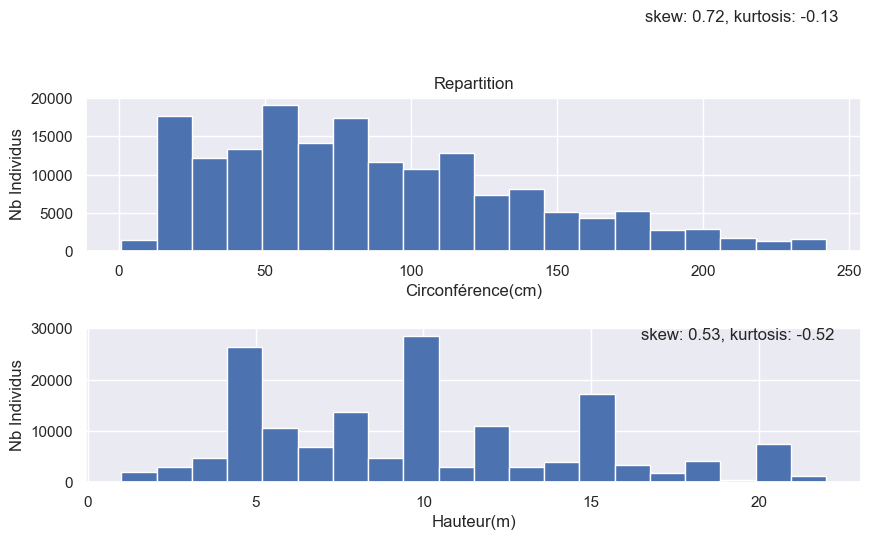

In [22]:
# Histogrammes circonferences et hauteurs
plt.figure(figsize=(10,5))
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

circonference_skew = df_circonference_filtered['circonference_cm'].skew()
circonference_kurtosis = df_circonference_filtered['circonference_cm'].kurtosis()
hauteur_skew = df_hauteur_filtered['hauteur_m'].skew()
hauteur_kurtosis = df_hauteur_filtered['hauteur_m'].kurtosis()

plt.subplot(2,1,1)
plt.title('Repartition')
plt.hist(df_circonference_filtered['circonference_cm'].values, bins=20)
plt.ylabel('Nb Individus')
plt.xlabel('Circonférence(cm)')
plt.text(180,30000,f'skew: {circonference_skew:0.2f}, kurtosis: {circonference_kurtosis:0.2f}')

plt.subplot(2,1,2)
plt.hist(df_hauteur_filtered['hauteur_m'].values, bins=20)
plt.ylabel('Nb Individus')
plt.xlabel('Hauteur(m)')
plt.subplots_adjust(hspace=0.5)
plt.text(16.5,28000,f'skew: {hauteur_skew:0.2f}, kurtosis: {hauteur_kurtosis:0.2f}')
plt.show()

- La distribution de la circonférence est étalée à droite avec une concentration légèrement moindre qu'une distribution normale 
- La distribution de la hauteur est presque centrée avec une concentration beaucoup moins accentuée qu'une distribution normale et des valeurs manquantes sur la courbe

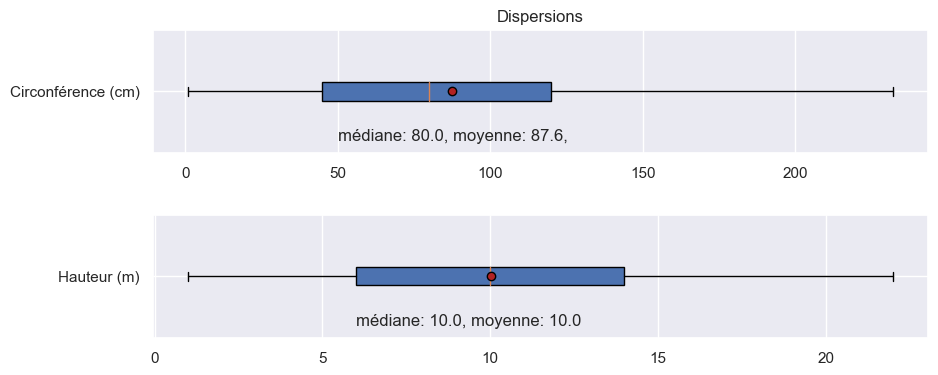

In [23]:
# Box plots circonferences et hauteurs
plt.figure(figsize=(10,4))
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

circonference_mean = df_circonference_filtered['circonference_cm'].mean()
circonference_median = df_circonference_filtered['circonference_cm'].median()
hauteur_mean = df_hauteur_filtered['hauteur_m'].mean()
hauteur_median = df_hauteur_filtered['hauteur_m'].median()

plt.subplot(2,1,1)
plt.title('Dispersions')
plt.boxplot(df_circonference_filtered['circonference_cm'].values, labels=['Circonférence (cm)'], showfliers=False, meanprops=meanprops, vert=False, patch_artist=True, showmeans=True)
plt.text(50,0.6,f'médiane: {circonference_median:0.1f}, moyenne: {circonference_mean:0.1f}, ')
plt.subplot(2,1,2)
plt.boxplot(df_hauteur_filtered['hauteur_m'].values, labels=['Hauteur (m)'], showfliers=False, meanprops=meanprops, vert=False, patch_artist=True, showmeans=True)
plt.text(6,0.6,f'médiane: {hauteur_median:0.1f}, moyenne: {hauteur_mean:0.1f}')
plt.subplots_adjust(hspace=0.5)
plt.show()

# 3. Synthèse de l'analyse de données

Le jeu de données comporte 200137 individus avec 18 colonnes.

La plupart de celles-ci sont qualitatives: emplacement ou espèce par exemple. 

Deux d'entre elles sont quantitatives: la circonférence et la hauteur des arbres.

L'analyse est effectuée sur ces deux valeurs numériques.

Après nettoyage des données manquantes, dupliquées et aberrantes basée sur la méthode des quartiles ou nulle:
- L'analyse de la circonférence se base sur 170681 individus.
- L'analyse de la hauteur se base sur 157015 individus.

<i>Il est noté à nouveau ici que les valeurs aberrantes auraient pu être écartées de manière encore plus franche, en utilisant des données issues de site web, publiant les valeurs maximum de circonférence/diamètre/hauteur des arbres à Paris</i>

<b>Concernant la circonférence des arbres:</b>

La moyenne (87cm) est proche de la médiane (80cm). Cela signifie que peu d'arbres sont hors de la norme (outliers).
<br>La dispersion s'étale principalement entre 45cm et 120cm. 
<br>C'est une dispersion plutot étalée à droite comme le montre le graphe en bar. On voit donc que les grandes circonférences sont moins représentées. <br>Cela signifie que les espèces présentes à Paris sont des espèces qui ne sont pas des espèces à fortes circonférence et/ou qu'il y a une majorité de jeunes arbres (le camenbert de repartition des individus par age nous le laisse penser, mais ce n'est pas franc car 34% n'y sont pas classés)
<br>Pour essayer de déduire si l'une ou l'autre des hypothèses ci dessus est vraie, il faudrait faire une analyse bivariée (circonférence/age - circonférence/espece)
<br>On note aussi que l'étalement est aussi plus applati qu'une courbe de distribution normale.

<b>Concernant la hauteur des arbres:</b>

La moyenne (10m) est égale de la médiane (10m). Très peu d'arbres sont hors de la norme (outliers).
<br>La dispersion s'etale principalement entre 6m et 14m. Elle représente mal une courbe normale de distribution car on y voit 3 valeurs sur-réprésentées. Soit les mesures sont estimées (et ne reflètent donc pas la réalité, auquel cas le graphe en bar devrait etre réduit à 6 ou 7 valeurs au lieu de 20), soit, comme pour la circonférence, les espèces et tranches d'age représentés jouent un rôle prépondérant. 



# BONUS: Quelques dispersions et répartitions

## 1. Circonférence en fonction de la hauteur

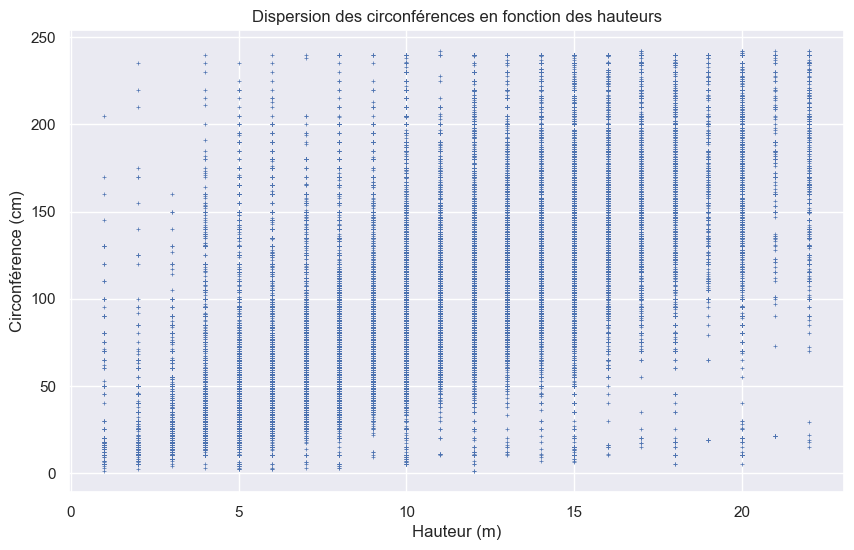

In [24]:
df_c_h = df.loc[filtre_circonference & filtre_hauteur, ['circonference_cm', 'hauteur_m']]
plt.figure(figsize=(10,6))
plt.scatter(df_c_h['hauteur_m'], df_c_h['circonference_cm'], marker='+', s=5, linewidths=0.5)
plt.title('Dispersion des circonférences en fonction des hauteurs')
plt.xlabel('Hauteur (m)')
plt.ylabel('Circonférence (cm)')
plt.show()

## 2. Quantité par domanialité

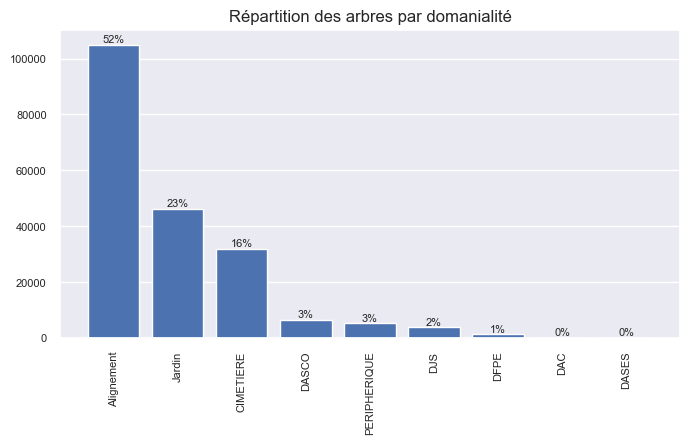

In [25]:
# Repartition
rep_domanialite = df.groupby(['domanialite'], dropna=True).size().sort_values(ascending=False)

# Graph
plt.figure(figsize=(8,4))
bar = plt.bar(rep_domanialite.index, rep_domanialite.values)
plt.xticks(rotation=90)
plt.title('Répartition des arbres par domanialité')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(axis='x')
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height/len(df)*100:.0f}%', ha='center', va='bottom', fontsize=8)

Plus de la moitié des arbres sont en Alignement et un presque un quart de ceux-ci dans les jardins.

## 3. Quantité par Arrondissement

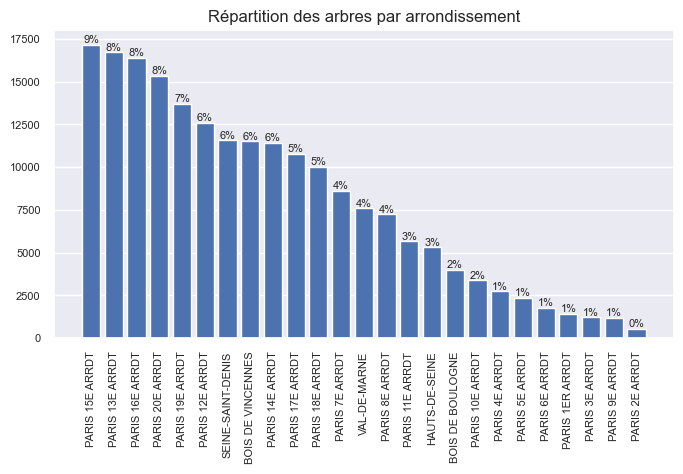

In [26]:
# Répartition
rep_arrondissement = df.groupby(['arrondissement'], dropna=True).size().sort_values(ascending=False)

# Graph
sns.set()
plt.figure(figsize=(8,4))
bar = plt.bar(rep_arrondissement.index, rep_arrondissement.values)
plt.xticks(rotation=90)
plt.title('Répartition des arbres par arrondissement')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(axis='x')
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height/len(df)*100:.0f}%', ha='center', va='bottom', fontsize=8)

Paris 15ième arrive en tête avec 9% des arbres de la ville

## 4. Les 10 espèces les plus présentes

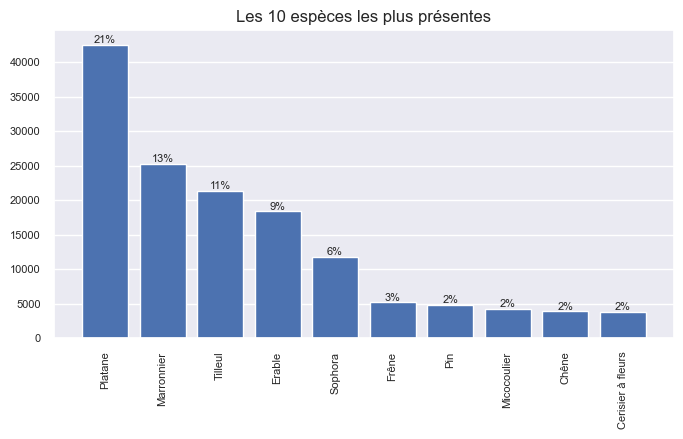

In [27]:
# Répartition
rep_libelle_francais_top_10 = df.groupby(['libelle_francais'], dropna=True).size().sort_values(ascending=False).head(10)

# Graph
plt.figure(figsize=(8,4))
bar = plt.bar(rep_libelle_francais_top_10.index, rep_libelle_francais_top_10.values)
plt.xticks(rotation=90)
plt.title('Les 10 espèces les plus présentes')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(axis='x')
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height/len(df)*100:.0f}%', ha='center', va='bottom', fontsize=8)

Les platanes sont largement en tête avec 21%. Les maronniers, tilleuils et érables sont aussi fortement représentés

## 5. Affichage des arbres sur la carte

**ATTENTION L'EXECUTION ET L'AFFICHAGE PEUVENT PRENDRE PLUSIEURS MINUTES**

In [28]:
generate_this_cell = False

# Centrage map sur Paris
paris_map = folium.Map(location = [48.85, 2.32], zoom_start = 12)

# Creation du cluster de markers
clustered_map = foliumPlugins.MarkerCluster().add_to(paris_map)

if generate_this_cell:
    # Ajouts des points geo2d au cluster
    for lat, lng, label, in zip(df_save['geo_point_2d_a'], df_save['geo_point_2d_b'], df_save['lieu']):
        folium.Marker(
            location=[lat, lng],
            icon=None,
             popup=label,
         ).add_to(clustered_map)

    # Affichage map
    paris_map
else:
    print('Set variable named "generate_this_cell" to True to view result')

Set variable named "generate_this_cell" to True to view result


## 6. Trajet minimum à partir d'un critère

In [29]:
from typing import Tuple
from pandas import DataFrame

# Fonction qui transfert la 1er ligne du dataframe origin à la fin du dataframe output (vide origin en remplissant output)
def transfert_nearest(origin: DataFrame, output: DataFrame) -> Tuple[DataFrame, DataFrame]:
    output = pd.concat([output, origin.head(1)], ignore_index=True)
    origin.drop(index=origin.head(1).index, inplace=True)
    return origin, output

# Fonction qui crée une map à partir du DataFrame classé
def create_map(sorted_dataframe: DataFrame):
    # Création Map et centrage map sur le 1er point
    created_map = folium.Map(location = [sorted_dataframe['geo_point_2d_a'].iloc[0],
                                         sorted_dataframe['geo_point_2d_b'].iloc[0]],
                             zoom_start = 18)

    # Ajouts de la polyline à la map
    points = []
    for lat, lng, index in zip(sorted_dataframe['geo_point_2d_a'],
                               sorted_dataframe['geo_point_2d_b'],
                               sorted_dataframe.index):
        points.append((lat, lng))
    
    folium.PolyLine(points).add_to(created_map)
    
    # result map
    return created_map


# Fonction qui calcul le trajet le plus court en fonction de critères et qui retourne la map
def display_map(use_filter):
    
    # initialisation: 
    #   origin est une copy filtrée des data d'origine
    #   output est le dataframe de sorti classé par chemin de proche en proche
    origin = df_save.loc[df_save[use_filter['name']].isin(use_filter['values']), :].copy()
    print(f'Nombre d\'arbres sur le chemin: {len(origin)}')
    origin.sort_values(['geo_point_2d_b', 'geo_point_2d_a'], ascending=True, inplace=True, ignore_index=True)
    output = pd.DataFrame()
    
    # Transfert du 1er point de origin vers output
    origin, output = transfert_nearest(origin, output)

    # Boucle de calcul du prochain point le plus proche, et transfert de celui-ci de origin dans output
    # On s'arrete quand origin est vide
    while len(origin) > 0:
        print(f'\rreste à traiter: {len(origin)}    ', end='', flush=True)
        ref_a = output['geo_point_2d_a'].iloc[-1]
        ref_b = output['geo_point_2d_b'].iloc[-1]
        origin['distance'] = (origin['geo_point_2d_a'] - ref_a)**2 + (origin['geo_point_2d_b'] - ref_b)**2
        origin.sort_values(['distance'], ascending=True, inplace=True, ignore_index=True)
        origin, output = transfert_nearest(origin, output)
    
    print('\r                      ', end='', flush=True)
        
    # Création Map et centrage map sur le 1er point
    return create_map(output)

# Exemple de filtrage possible
filter1 = {'name': 'libelle_francais', 'values': ['Noyer']} # Pin, Chêne, Charme, If
filter2 = {'name': 'arrondissement', 'values': ['PARIS 7E ARRDT']}
filter3 = {'name': 'domanialite', 'values': ['CIMETIERE']} # PERIPHERIQUE


# Affichage du chemin filtré
display_map(filter2)

Nombre d'arbres sur le chemin: 8617
                         